In [2]:
##imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas.tools import geocode
import requests
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm

##load starbucks data
starbucks_df = pd.read_csv("C:/Users/Rbrig/OneDrive/Documents/GIS Projects/GIS 322/Starbucks.csv/starbucks_address.csv")  # Adjust path if needed

##display first few rows
print(starbucks_df.head())

##full addresses
starbucks_df["full_address"] = (
    starbucks_df["Street Address"].fillna("") + ", " +
    starbucks_df["City"].fillna("") + ", " +
    starbucks_df["State/Province"].fillna("") + ", USA"
)

##check for Photon geocoding service
try:
    response = requests.get("https://photon.komoot.io/api?q=Los+Angeles", timeout=10)
    if response.status_code == 200:
        print("Photon service is reachable. Proceeding with geocoding...")
        photon_ok = True
    else:
        print("Photon service returned an error.")
        photon_ok = False
except Exception as e:
    print("Photon service is not reachable:", e)
    photon_ok = False


       Brand                     Store Name  \
0  Starbucks               Fry's #78 Anthem   
1  Starbucks          Anthem & I-17, Anthem   
2  Starbucks  Daisy Mountain & Gavilan Peak   
3  Starbucks  Fry's-Apache Junction, AZ #65   
4  Starbucks        Apache Trail & Delaware   

                        Street Address             City State/Province Country  
0        39508 N. Daisy Mountain Drive           Anthem             AZ      US  
1                   3640 W. Anthem Way           Anthem             AZ      US  
2  39504 N. Daisy Mountain Drive, #118           Anthem             AZ      US  
3                      185 W Apache Tr  Apache Junction             AZ      US  
4                 2580 W. Apache Trail  Apache Junction             AZ      US  
Photon service is not reachable: HTTPSConnectionPool(host='photon.komoot.io', port=443): Read timed out. (read timeout=10)


In [3]:
##geocoder w/ longer timeout
geolocator = Nominatim(user_agent="az_starbucks_locator", timeout=10)

##longer delay
geocode_fn = RateLimiter(geolocator.geocode, min_delay_seconds=1.2, max_retries=3, error_wait_seconds=10.0)

tqdm.pandas()

##geocoding
starbucks_df["location"] = starbucks_df["full_address"].progress_apply(geocode_fn)

##full address
starbucks_df["location"] = starbucks_df["full_address"].progress_apply(geocode_fn)

##latitude and longitude
starbucks_df["latitude"] = starbucks_df["location"].apply(lambda loc: loc.latitude if loc else None)
starbucks_df["longitude"] = starbucks_df["location"].apply(lambda loc: loc.longitude if loc else None)

##drop rows w/o coordinates
starbucks_df = starbucks_df.dropna(subset=["latitude", "longitude"])

##convert to GeoDataFrame
geo_starbucks = gpd.GeoDataFrame(
    starbucks_df,
    geometry=gpd.points_from_xy(starbucks_df["longitude"], starbucks_df["latitude"]),
    crs="EPSG:4326"
)

##result
geo_starbucks.head()




00%|████████████████████████████████████████████████████████████████████████████████| 488/488 [10:52<00:00,  1.34s/it]

,Brand,Store Name,Street Address,City,State/Province,Country,full_address,location,latitude,longitude,geometry
0,Starbucks,Fry's #78 Anthem,39508 N. Daisy Mountain Drive,Anthem,AZ,US,"39508 N. Daisy Mountain Drive, Anthem, AZ, USA","(North Daisy Mountain Drive, Anthem, Maricopa ...",33.852091,-112.115609,POINT (-112.11561 33.85209)
1,Starbucks,"Anthem & I-17, Anthem",3640 W. Anthem Way,Anthem,AZ,US,"3640 W. Anthem Way, Anthem, AZ, USA","(Starbucks, 3640, West Anthem Way, Phoenix, Ma...",33.866754,-112.136847,POINT (-112.13685 33.86675)
2,Starbucks,Daisy Mountain & Gavilan Peak,"39504 N. Daisy Mountain Drive, #118",Anthem,AZ,US,"39504 N. Daisy Mountain Drive, #118, Anthem, A...","(North Daisy Mountain Drive, Anthem, Maricopa ...",33.859055,-112.112403,POINT (-112.1124 33.85906)
4,Starbucks,Apache Trail & Delaware,2580 W. Apache Trail,Apache Junction,AZ,US,"2580 W. Apache Trail, Apache Junction, AZ, USA","(Starbucks, 2580, West Apache Trail, Apache Ju...",33.415975,-111.574146,POINT (-111.57415 33.41597)
8,Starbucks,"Indian School & 107 Ave, Avondale",10585 W. Indian School Rd,Avondale,AZ,US,"10585 W. Indian School Rd, Avondale, AZ, USA","(10585, West Indian School Road, Avondale, Mar...",33.493239,-112.286775,POINT (-112.28677 33.49324)


CRS: EPSG:4269


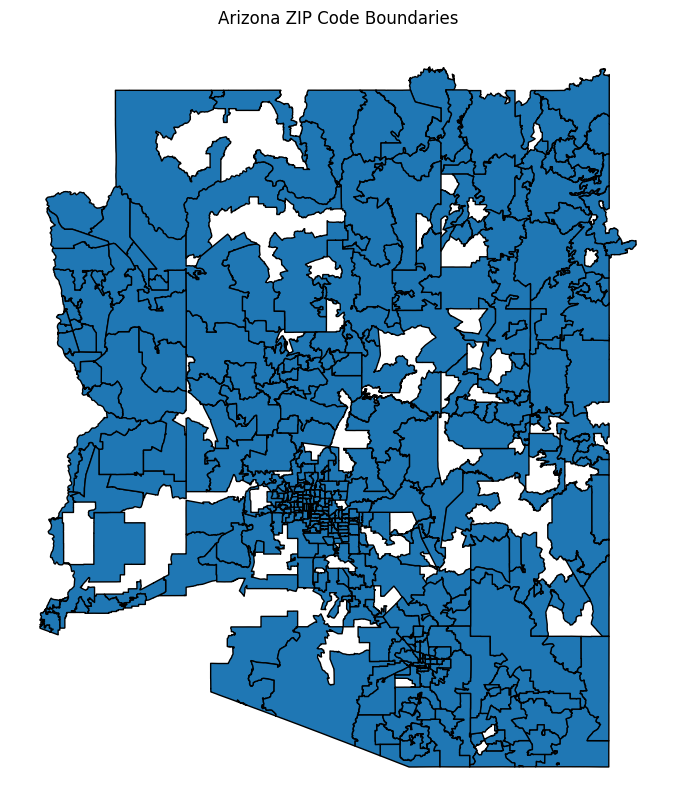

In [8]:
##load Arizona ZIP code shapefile
zipcodes_gdf = gpd.read_file("C:\\Users\\Rbrig\\OneDrive\\Documents\\GIS Projects\\GIS 322\\AZ_Zipcodes\\AZ_zipcodes\\AZ_zipcodes.shp")

##coordinate reference system
print("CRS:", zipcodes_gdf.crs)

##plot 
zipcodes_gdf.plot(edgecolor="black", figsize=(10, 10))
plt.title("Arizona ZIP Code Boundaries")
plt.axis("off")
plt.show()


In [9]:
##both GeoDataFrames use same coordinate system
zipcodes_gdf = zipcodes_gdf.to_crs(geo_starbucks.crs)

##spatial join (attach ZIP code info to each Starbucks location)
joined = gpd.sjoin(geo_starbucks, zipcodes_gdf, how="inner", predicate="within")

##join result
print(joined.head())


       Brand                         Store Name  \
0  Starbucks                   Fry's #78 Anthem   
1  Starbucks              Anthem & I-17, Anthem   
2  Starbucks      Daisy Mountain & Gavilan Peak   
4  Starbucks            Apache Trail & Delaware   
8  Starbucks  Indian School & 107 Ave, Avondale   

                        Street Address             City State/Province  \
0        39508 N. Daisy Mountain Drive           Anthem             AZ   
1                   3640 W. Anthem Way           Anthem             AZ   
2  39504 N. Daisy Mountain Drive, #118           Anthem             AZ   
4                 2580 W. Apache Trail  Apache Junction             AZ   
8            10585 W. Indian School Rd         Avondale             AZ   

  Country                                       full_address  \
0      US     39508 N. Daisy Mountain Drive, Anthem, AZ, USA   
1      US                3640 W. Anthem Way, Anthem, AZ, USA   
2      US  39504 N. Daisy Mountain Drive, #118, Anthem, 

In [19]:
##check the column that contains ZIP codes
print(joined.columns)


Index(['Brand', 'Store Name', 'Street Address', 'City', 'State/Province',
       'Country', 'full_address', 'location', 'latitude', 'longitude',
       'geometry', 'index_right', 'ZCTA5CE10', 'GEOID10', 'CLASSFP10',
       'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10',
       'INTPTLON10', 'Zipcode'],
      dtype='object')


In [20]:
##group and count Starbucks per ZIP
starbucks_counts = joined.groupby("ZCTA5CE10").size().reset_index(name="starbucks_count")

##merge back w/ ZIP polygons
zipcodes_gdf = zipcodes_gdf.merge(starbucks_counts, on="ZCTA5CE10", how="left")

##fill NaN counts w/ 0
zipcodes_gdf["starbucks_count"] = zipcodes_gdf["starbucks_count"].fillna(0)


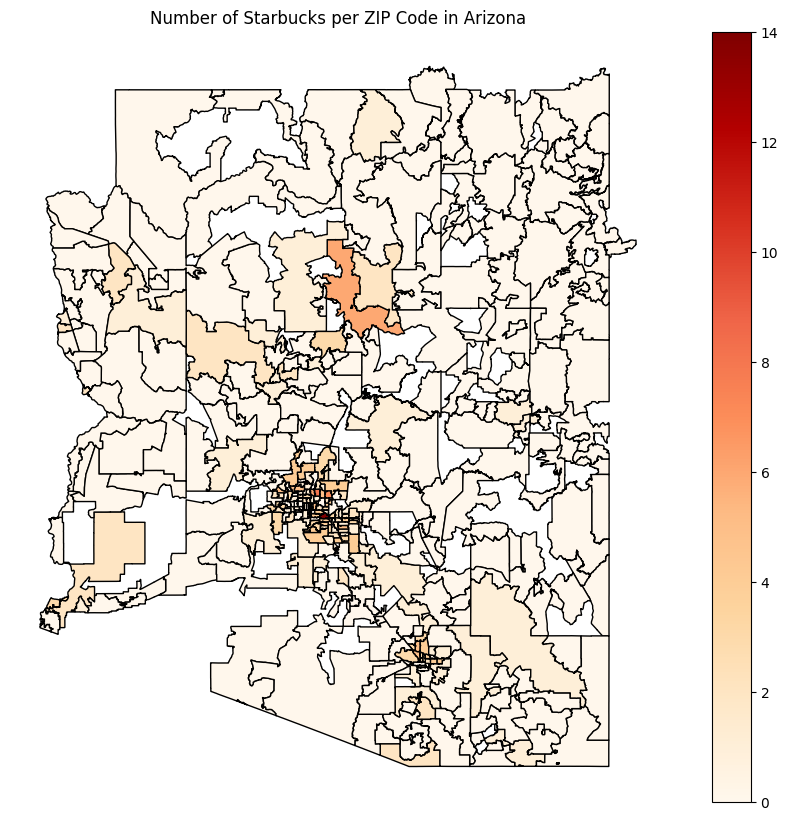

In [21]:
##plot w/ starbucks counts per ZIP
zipcodes_gdf.plot(
    column="starbucks_count",
    cmap="OrRd",
    legend=True,
    edgecolor="black",
    figsize=(12, 10)
)
plt.title("Number of Starbucks per ZIP Code in Arizona")
plt.axis("off")
plt.show()


<Figure size 1200x1000 with 0 Axes>

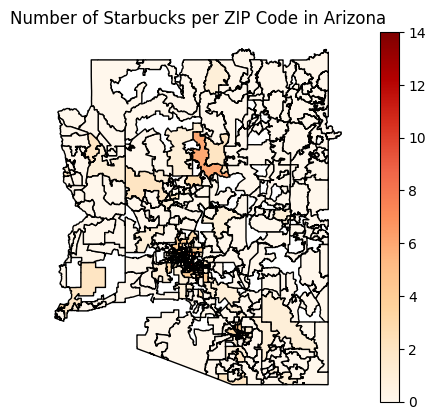

In [22]:
##save map as PNG
plt.figure(figsize=(12, 10))
zipcodes_gdf.plot(column="starbucks_count", cmap="OrRd", legend=True, edgecolor="black")
plt.title("Number of Starbucks per ZIP Code in Arizona")
plt.axis("off")
plt.savefig("starbucks_by_zip.png", dpi=300, bbox_inches="tight")
plt.show()


In [14]:
zipcodes_gdf = zipcodes_gdf.rename(columns={"starbucks_count": "sbux_count"})
zipcodes_gdf.to_file("starbucks_zipcodes_output.shp")